### Exploratory Data Analysis

#### Import Dependencies

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Define any helper functions

In [2]:
def plot_corr_matrix(matrix):
    f, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(corr_matrix, annot=True)
    plt.suptitle('Correlation Matrix')
    plt.show()

In [31]:
def plot_resampling_results(y_resampled, title):
    plt.figure(figsize=(4,4))
    pd.Series(y_resampled).value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    plt.title(title)
    plt.show()

#### Here is our XGBoost class we will utilize for any XGBoost model training

In [3]:
class XGBoostClassifierModel:
    def __init__(self, params=None, seed=42):
        # Default parameters for XGBoost
        default_params = {
            'objective': 'binary:logistic',
            'seed': seed
        }
        # Update default parameters with any provided params
        self.params = {**default_params, **(params or {})}
        self.model = xgb.XGBClassifier(**self.params)
        self.best_params = None
    
    def fit(self, X_train, y_train, X_test, y_test, early_stopping_rounds=10, eval_metric='auc', verbose=True):
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=early_stopping_rounds,
            eval_metric=eval_metric,
            verbose=verbose
        )
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def plot_confusion_matrix(self, y_test, y_pred, labels):
        conf_m = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_m, display_labels=labels)
        disp.plot()
        plt.show()
        return conf_m
    
    def get_metrics(self, conf_m):
        TP = conf_m[1, 1]  # True Positives
        FP = conf_m[0, 1]  # False Positives
        FN = conf_m[1, 0]  # False Negatives
        
        # Calculate Precision, Recall, and F1 score
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)

        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1_score)
        
        return {
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        }

    def tune_hyperparameters(self, X, y, param_grid, scoring='roc_auc', cv=3, verbose=3, n_jobs=10):
        grid_search = GridSearchCV(
            estimator=xgb.XGBClassifier(objective='binary:logistic', seed=self.params['seed']),
            param_grid=param_grid,
            scoring=scoring,
            verbose=verbose,
            n_jobs=n_jobs,
            cv=cv
        )
        grid_search.fit(X, y)
        self.best_params = grid_search.best_params_
        print(f"Best Parameters: {self.best_params}")
        self.model = xgb.XGBClassifier(**self.best_params, objective='binary:logistic', seed=self.params['seed'])
    
    def fit_with_best_params(self, X_train, y_train, X_test, y_test, early_stopping_rounds=10, eval_metric='auc', verbose=True):
        if self.best_params:
            self.model.fit(
                X_train, y_train,
                eval_set=[(X_test, y_test)],
                early_stopping_rounds=early_stopping_rounds,
                eval_metric=eval_metric,
                verbose=verbose
            )
        else:
            raise ValueError("No best parameters found. Please run tune_hyperparameters first.")


### Import Dataset

In [4]:
df = pd.read_csv("Loan_default.csv")

In [5]:
df.head(10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0
5,A9S62RQ7US,25,90298,90448,720,18,2,22.72,24,0.10,High School,Unemployed,Single,Yes,No,Business,Yes,1
6,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,Bachelor's,Unemployed,Single,Yes,No,Home,Yes,0
7,0HGZQKJ36W,56,126802,155511,531,67,4,8.15,60,0.43,PhD,Full-time,Married,No,No,Home,Yes,0
8,1R0N3LGNRJ,36,42053,92357,827,83,1,23.94,48,0.20,Bachelor's,Self-employed,Divorced,Yes,No,Education,No,1
9,CM9L1GTT2P,40,132784,228510,480,114,4,9.09,48,0.33,High School,Self-employed,Married,Yes,No,Other,Yes,0


### Identify basic dataframe information (variable types, counts, etc)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

### Check for NULLs

In [7]:
df.isnull().sum()

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

#### Check Target Variable Distributions

C:\Users\oshan\AppData\Local\Temp\ipykernel_11732\514204292.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Default',data=df,ax=ax[1], palette=['#037d97', '#E4591E'])


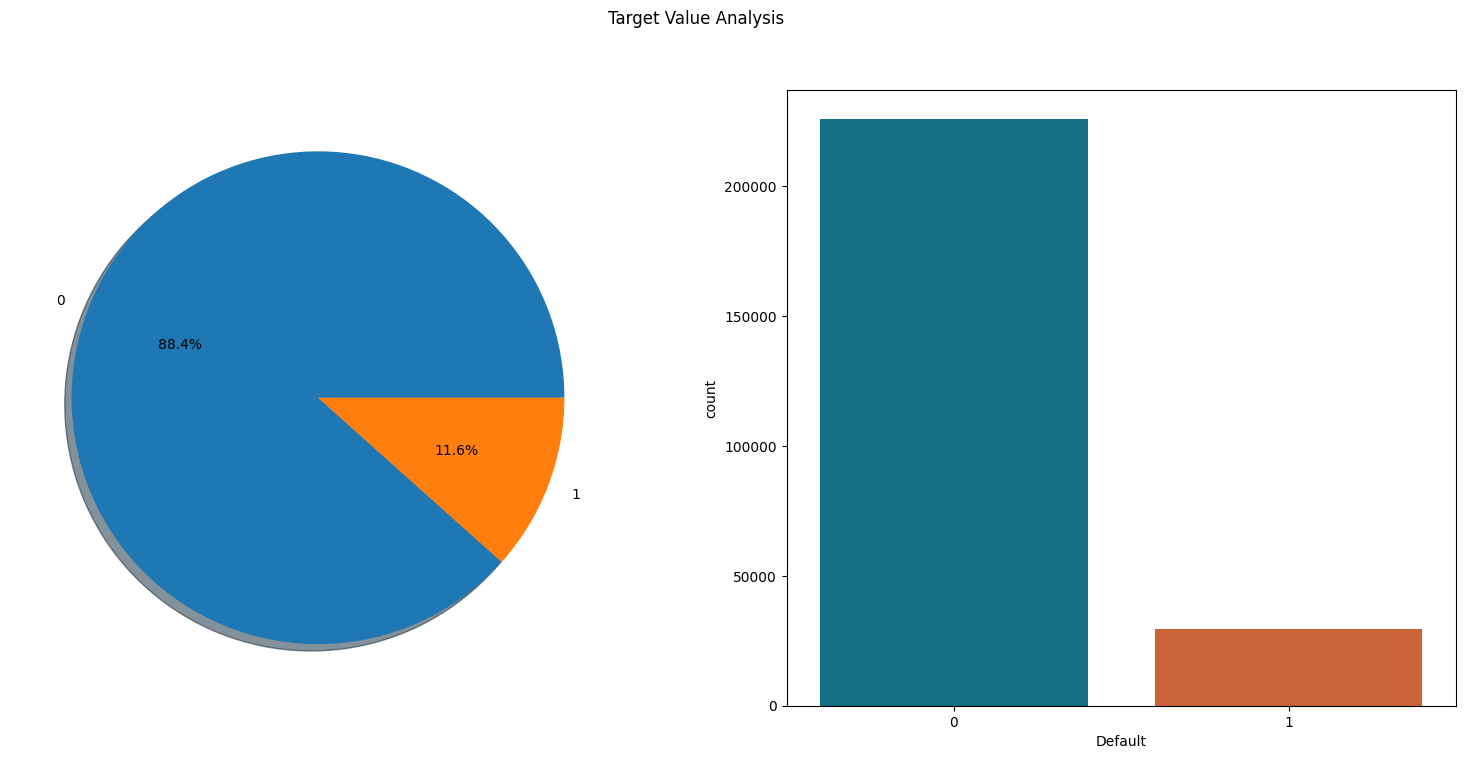

In [8]:
f,ax=plt.subplots(1,2,figsize=(19,8))
df['Default'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
sns.countplot(x='Default',data=df,ax=ax[1], palette=['#037d97', '#E4591E'])
plt.suptitle('Target Value Analysis')
plt.show()

#### Separate categorical and continuous variables

In [9]:
cat_vars = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
cont_vars = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

#### Plot categorical variables

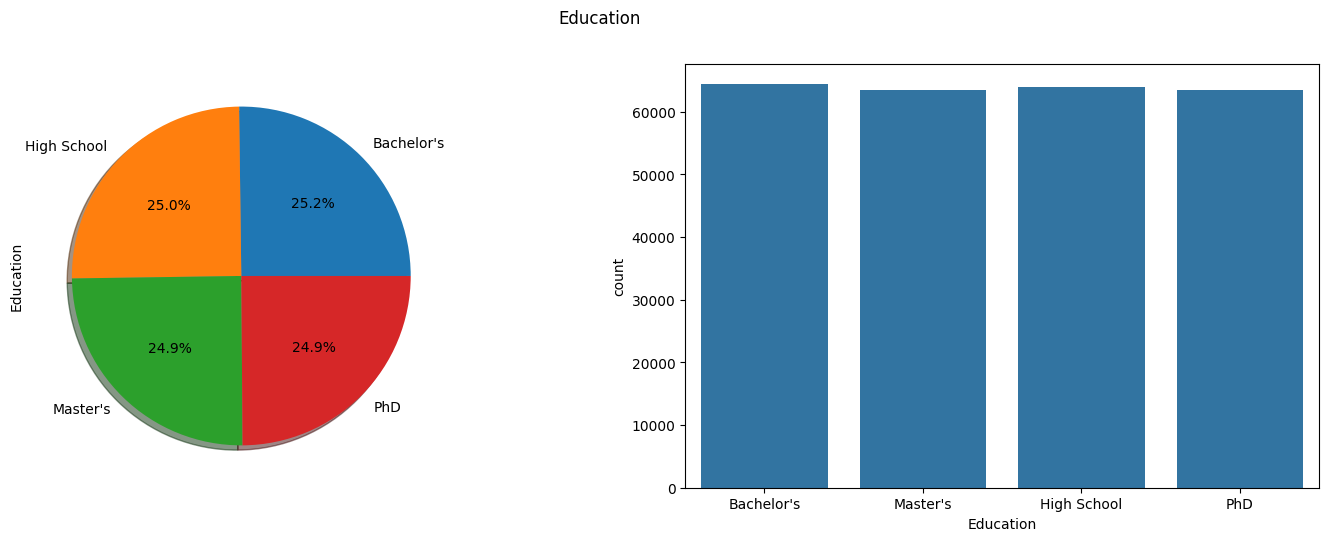

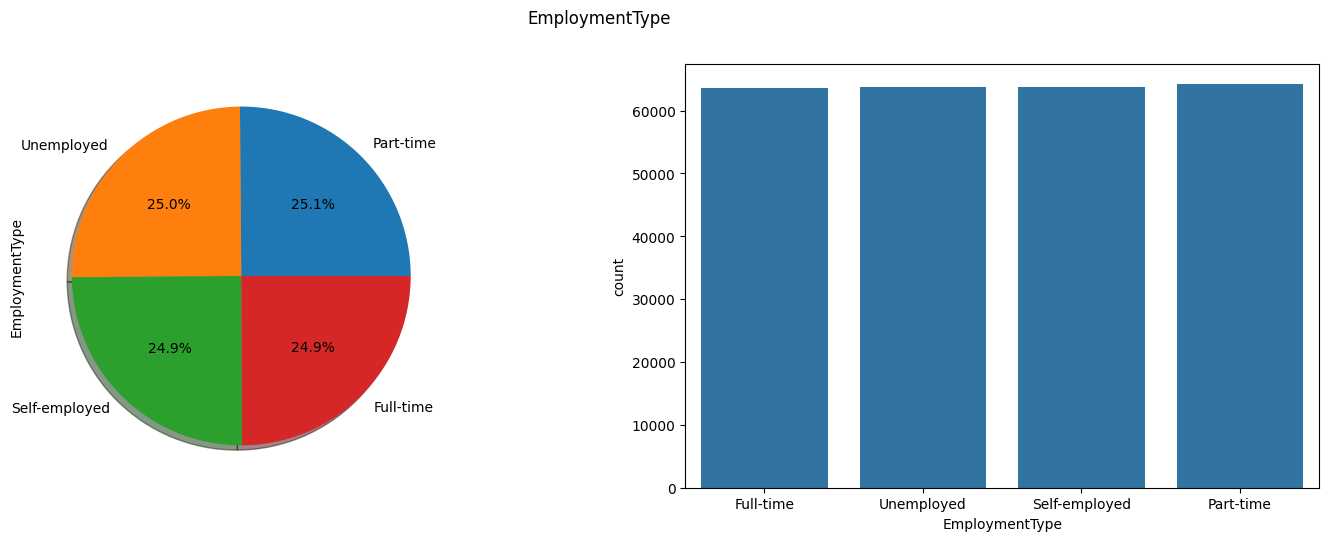

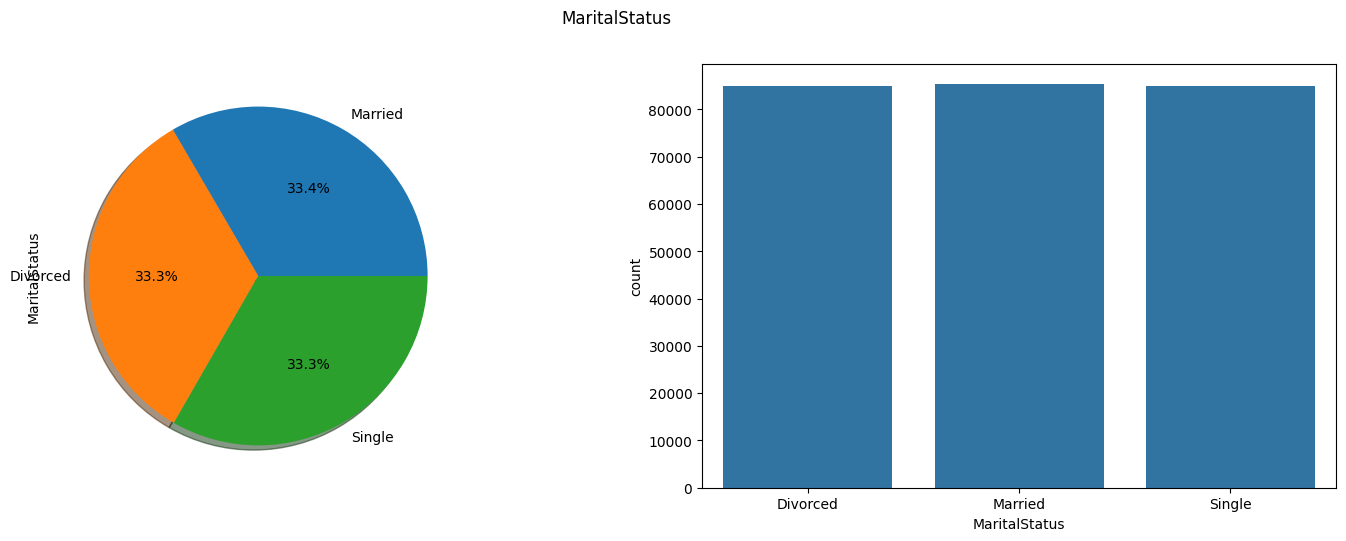

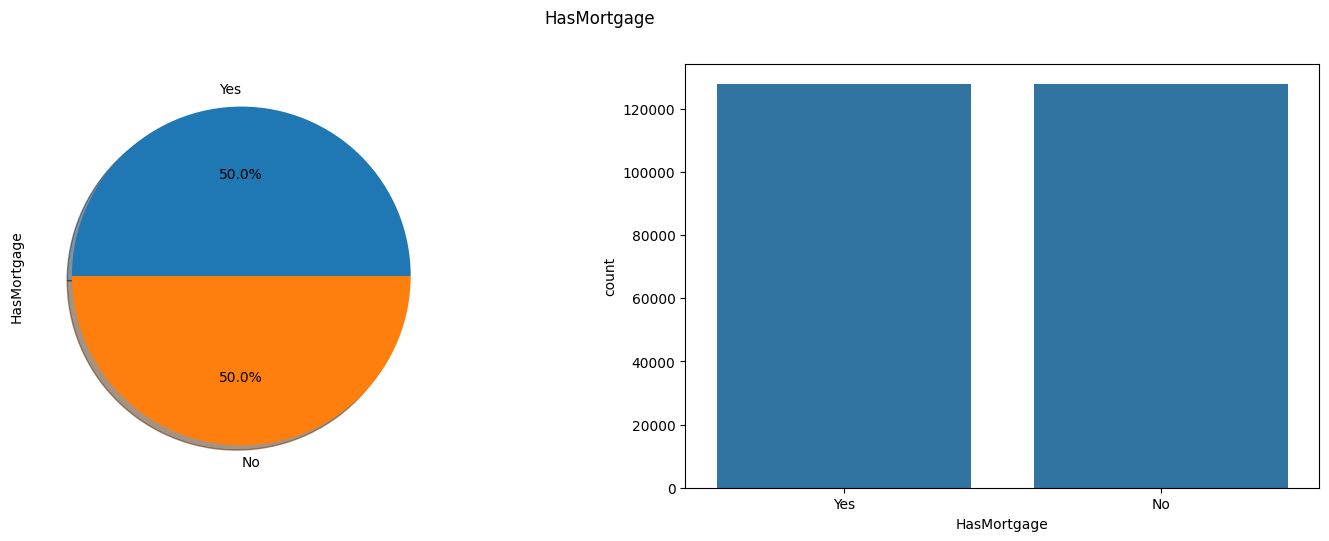

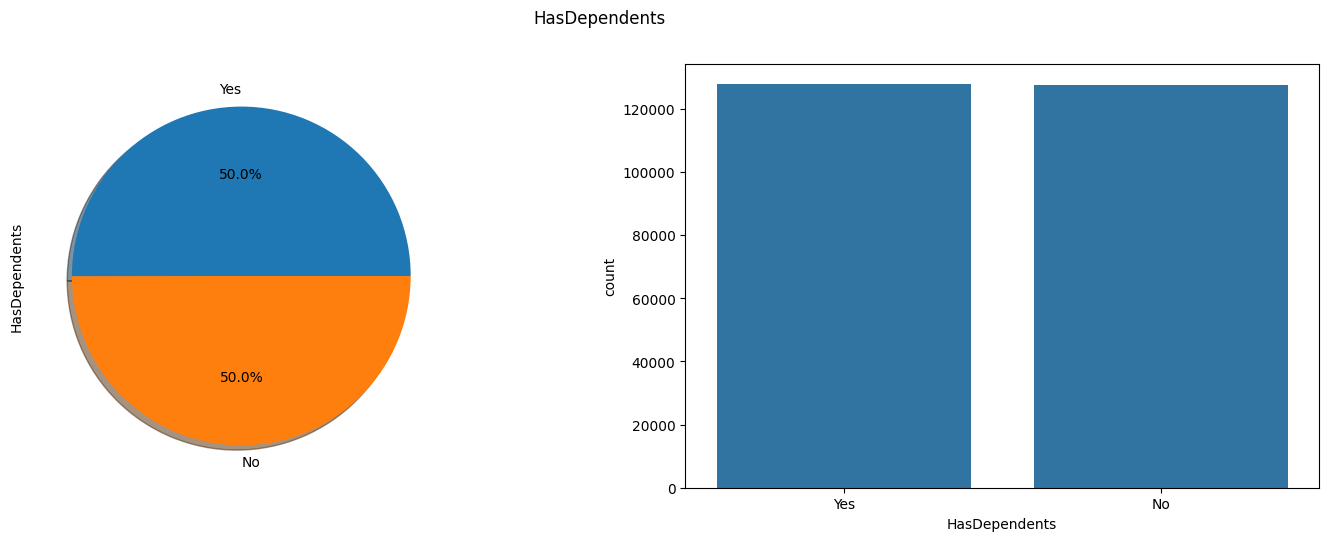

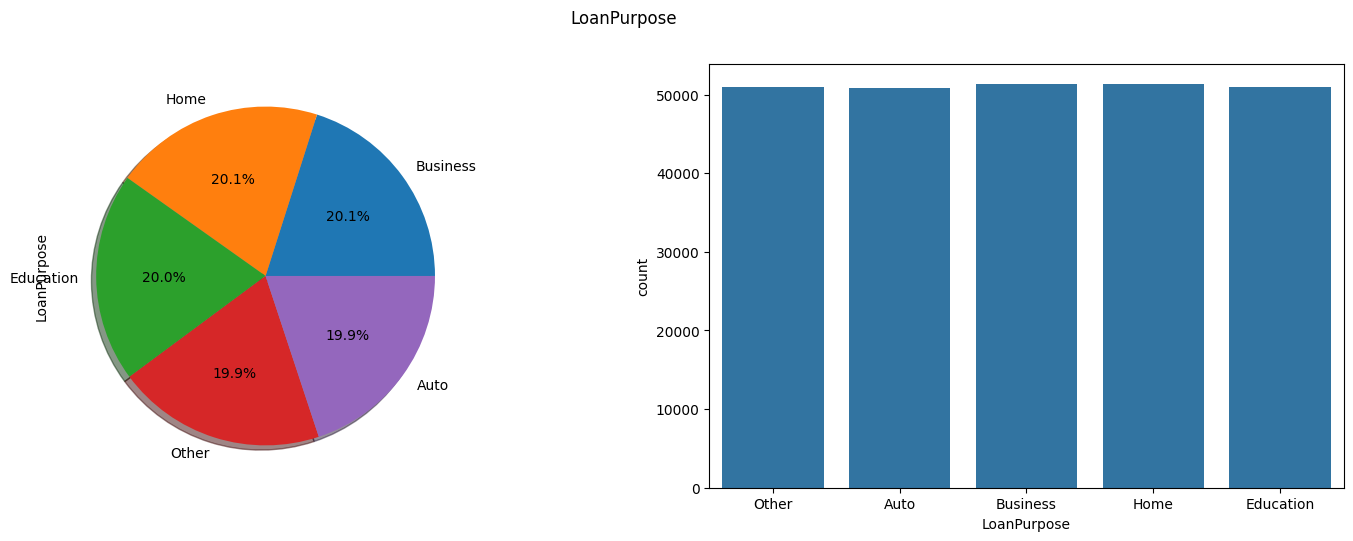

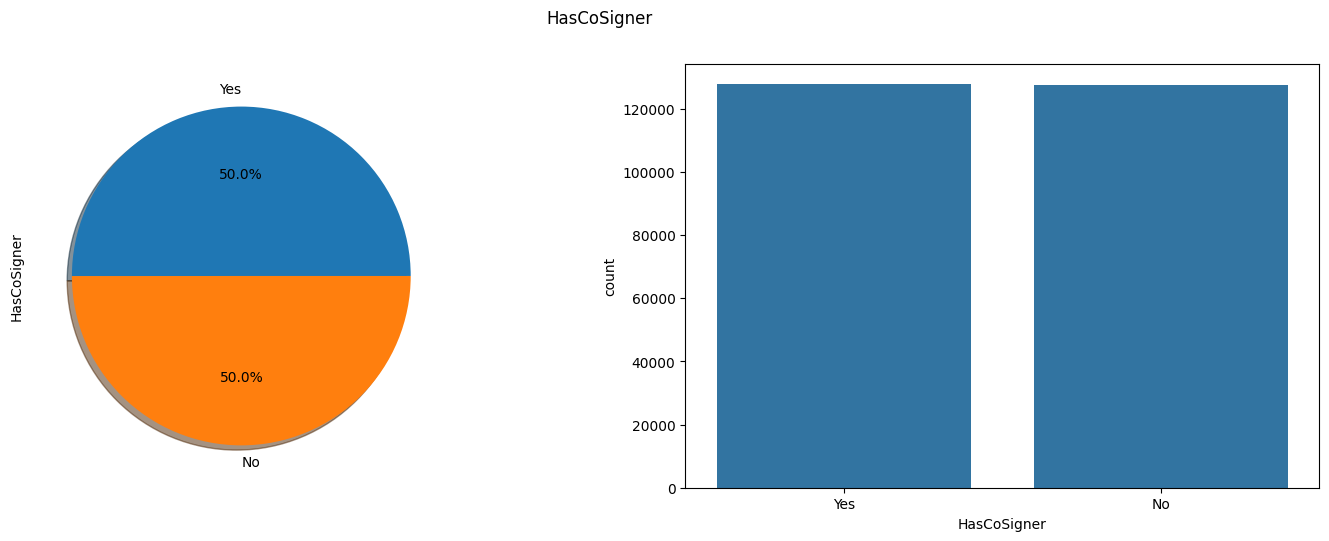

In [10]:
for var in cat_vars:
    f,ax=plt.subplots(1,2,figsize=(18,5.5))
    df[var].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{var}')
    sns.countplot(x=var,data=df,ax=ax[1])
    plt.suptitle(f'{var}')
    plt.show()

#### Plot numerical variables

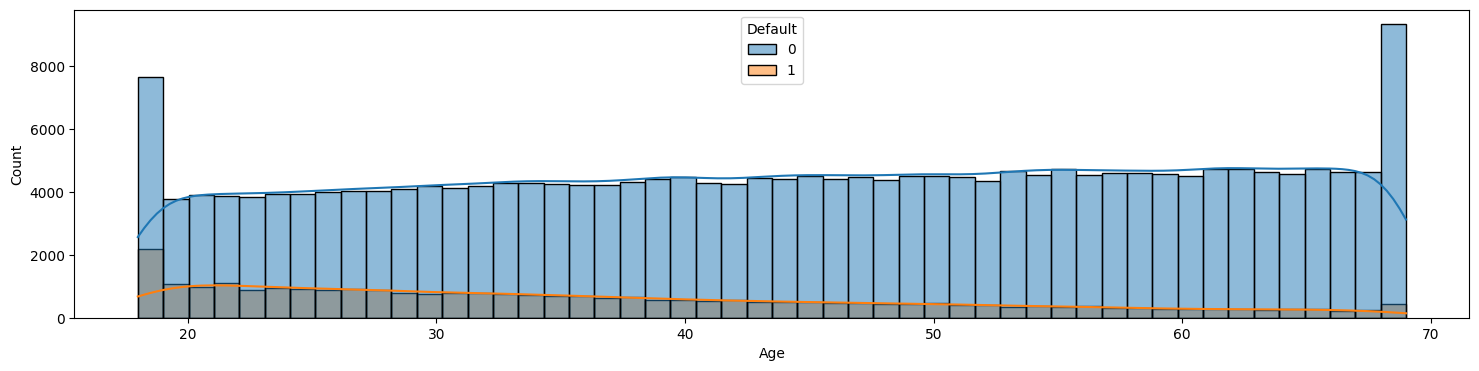

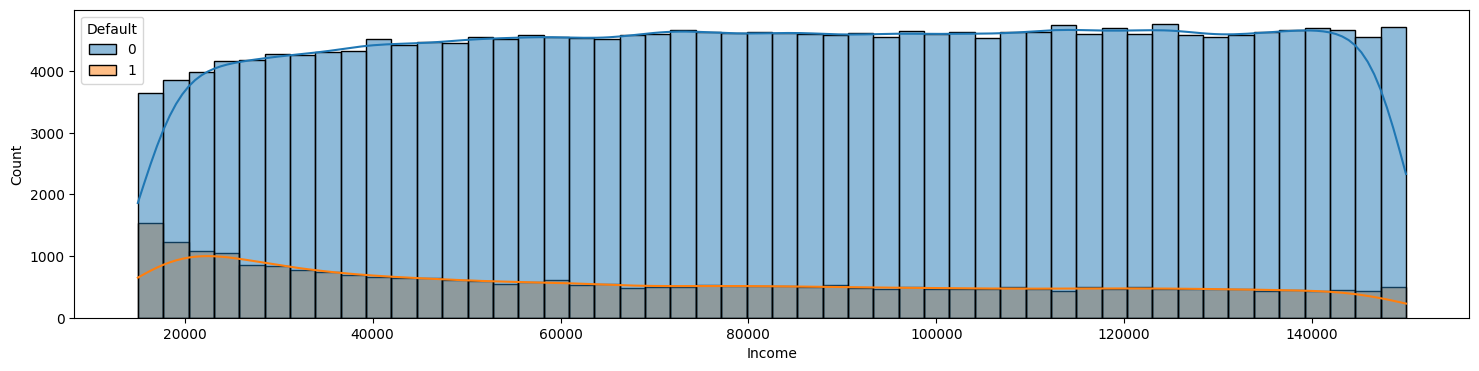

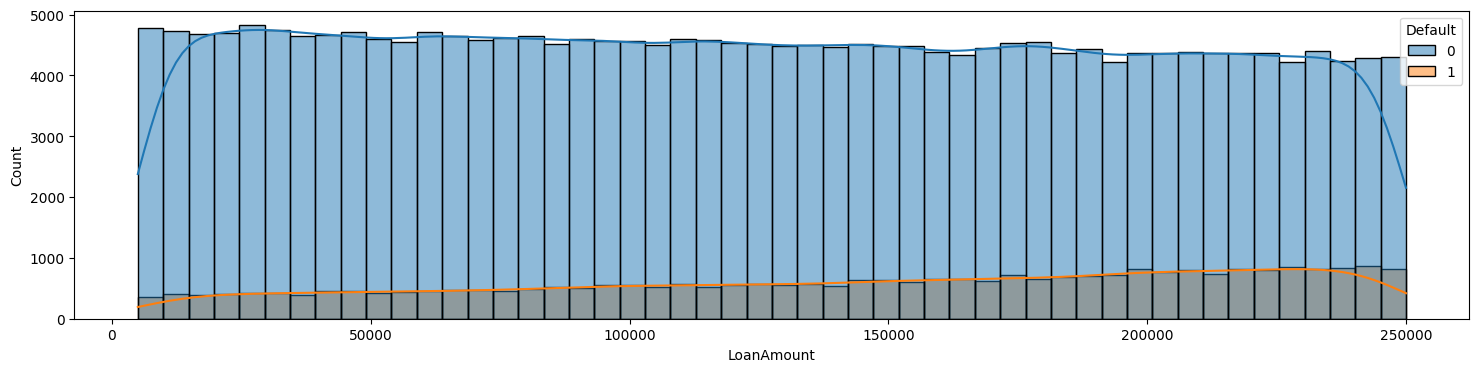

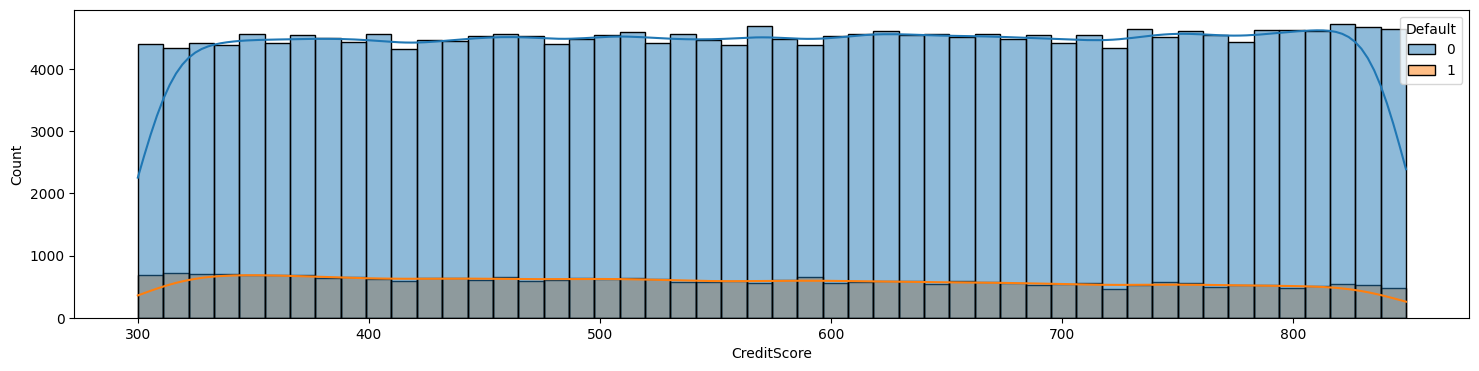

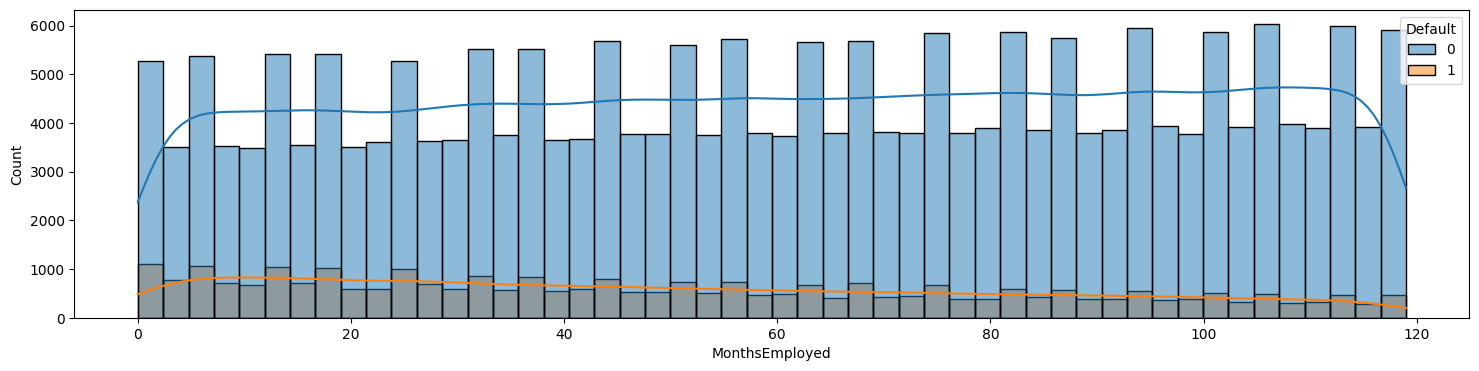

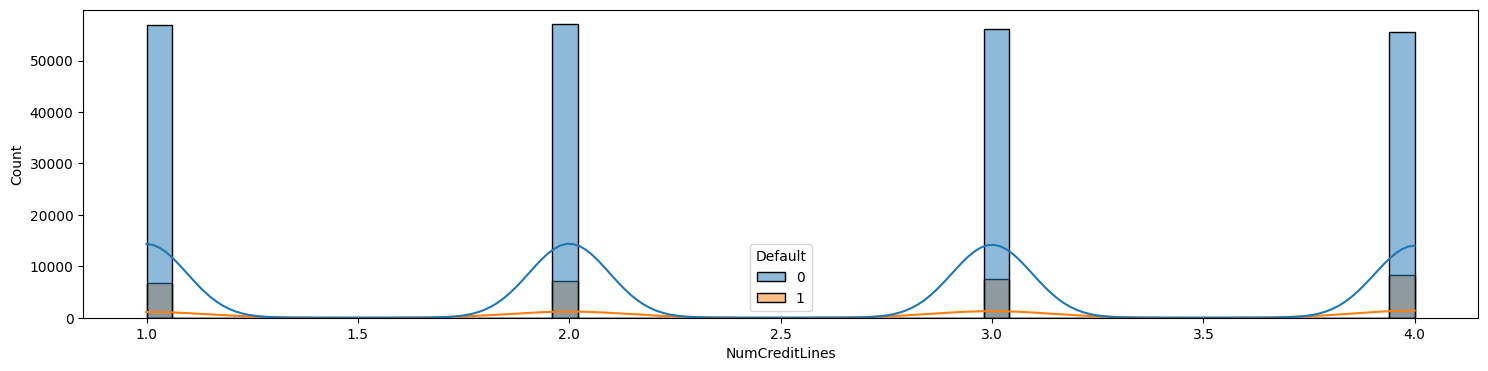

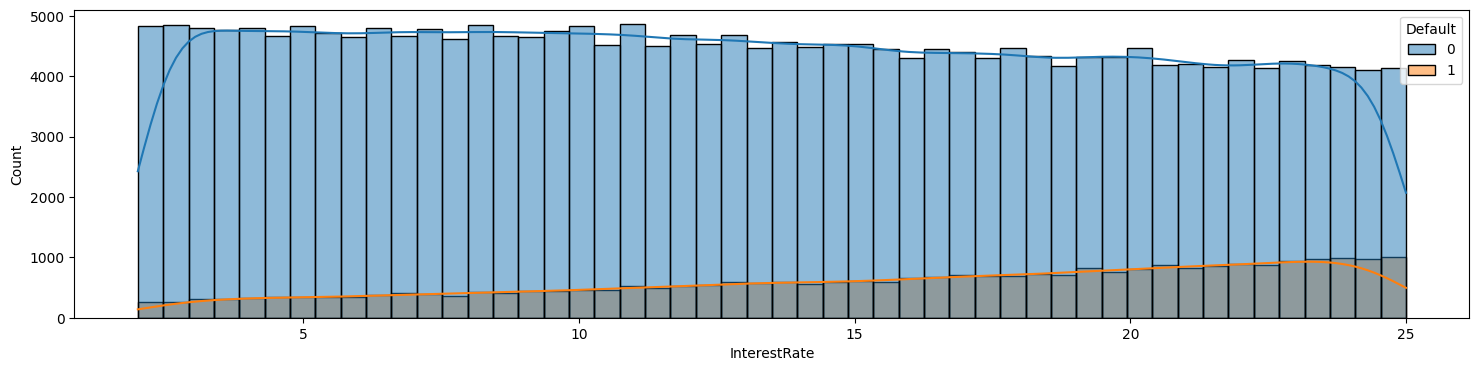

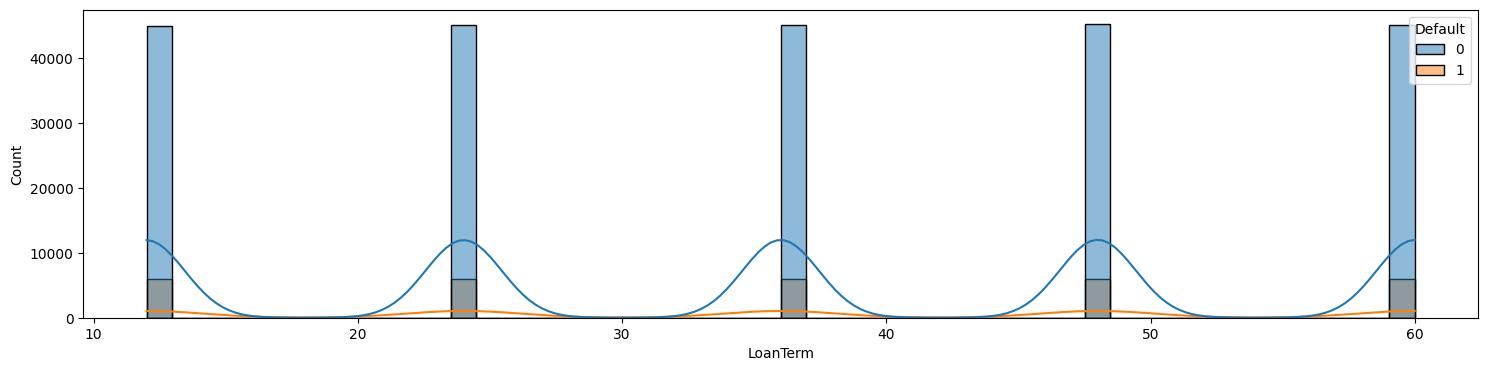

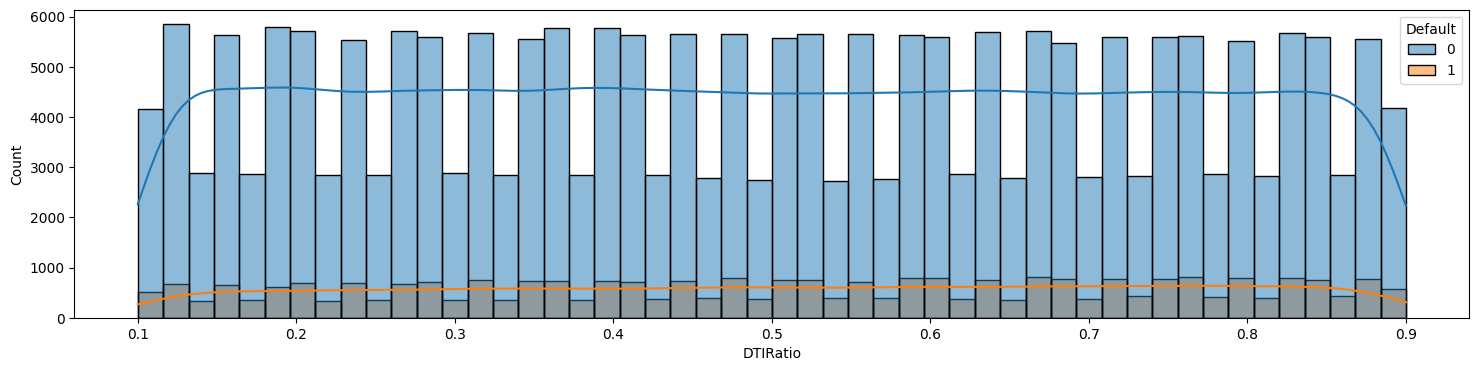

In [11]:
for var in cont_vars:
    fig, ax = plt.subplots(figsize=(18, 4))
    fig = sns.histplot(data=df, x=var, hue="Default", bins=50, kde=True)
    plt.show()

#### Visualize a correlation matrix

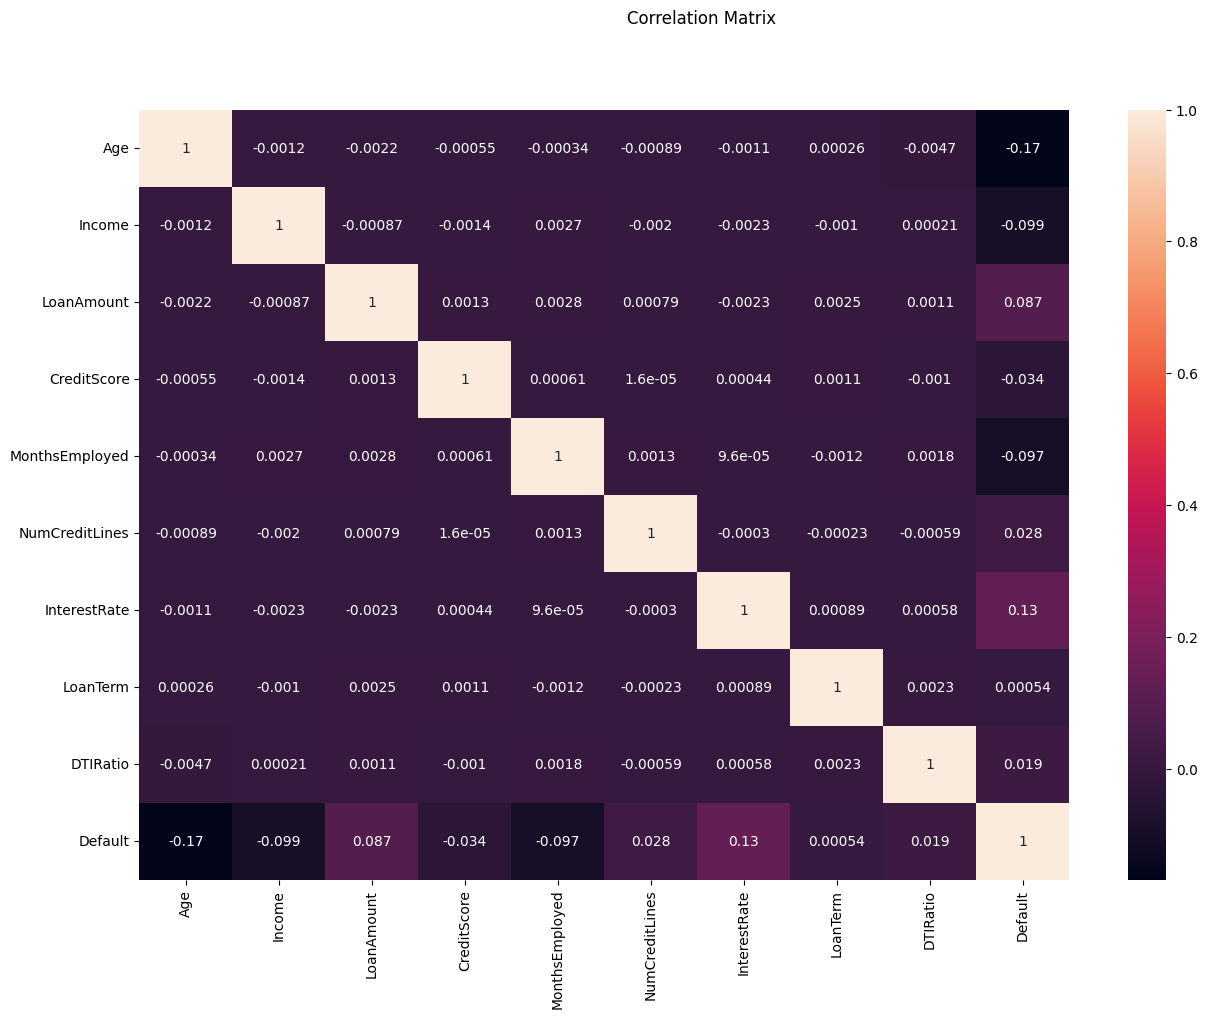

In [12]:
df_corr_check = df[['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default']].copy()
corr_matrix = df_corr_check.corr()
plot_corr_matrix(corr_matrix)

#### Separate target variable from independent variables

In [13]:
X = df.drop(['LoanID', 'Default'],axis=1)
y = df['Default']

#### Use One-Hot encoding for categorical variables

In [14]:
X_encoded = pd.get_dummies(X, columns=['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'])

#### Separate dataframe into train and test splits

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

#### Initialize our first XGBoost Model

In [16]:
xgb_v1 = XGBoostClassifierModel()

#### Setup our hyperparameter tuning grid

In [17]:
param_grid = {
        'n_estimators': [100, 400, 600],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.001, 0.01, 0.1]
    }

#### Find best hyperparameters

In [18]:
xgb_v1.tune_hyperparameters(X_train, y_train, param_grid)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


#### Fit XGBoost model with optimal parameters

In [19]:
xgb_v1.fit_with_best_params(X_train, y_train, X_test, y_test)

C:\Users\oshan\anaconda3\envs\XGBoost\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\oshan\anaconda3\envs\XGBoost\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.70513
[1]	validation_0-auc:0.71427
[2]	validation_0-auc:0.72248
[3]	validation_0-auc:0.72563
[4]	validation_0-auc:0.72717
[5]	validation_0-auc:0.72940
[6]	validation_0-auc:0.73113
[7]	validation_0-auc:0.73252
[8]	validation_0-auc:0.73460
[9]	validation_0-auc:0.73529
[10]	validation_0-auc:0.73647
[11]	validation_0-auc:0.73756
[12]	validation_0-auc:0.73868
[13]	validation_0-auc:0.73911
[14]	validation_0-auc:0.73977
[15]	validation_0-auc:0.74027
[16]	validation_0-auc:0.74100
[17]	validation_0-auc:0.74181
[18]	validation_0-auc:0.74267
[19]	validation_0-auc:0.74370
[20]	validation_0-auc:0.74409
[21]	validation_0-auc:0.74488
[22]	validation_0-auc:0.74562
[23]	validation_0-auc:0.74658
[24]	validation_0-auc:0.74714
[25]	validation_0-auc:0.74761
[26]	validation_0-auc:0.74840
[27]	validation_0-auc:0.74891
[28]	validation_0-auc:0.74908
[29]	validation_0-auc:0.74925
[30]	validation_0-auc:0.74982
[31]	validation_0-auc:0.75016
[32]	validation_0-auc:0.75075
[33]	validation_0-au

#### Make model predictions and get the confusion matrix and related evaluation metrics

In [21]:
y_pred = xgb_v1.predict(X_test)

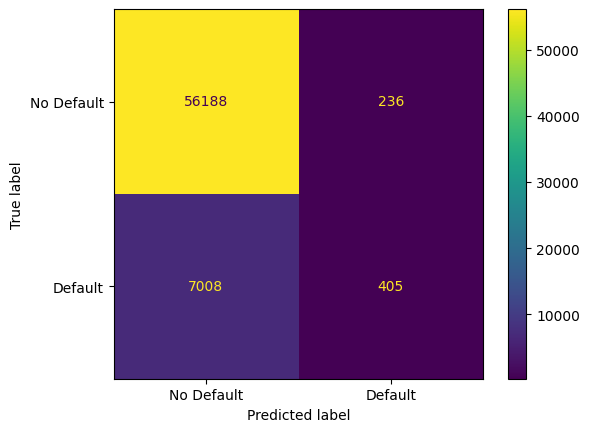

In [22]:
conf_m = xgb_v1.plot_confusion_matrix(y_test, y_pred, labels=['No Default', 'Default'])

In [23]:
xgb_v1.get_metrics(conf_m)

Precision: 0.6318252730109204
Recall: 0.05463375151760421
F1 Score: 0.10057114477278371


{'Precision': 0.6318252730109204,
 'Recall': 0.05463375151760421,
 'F1 Score': 0.10057114477278371}

##### Summary

We can see the evaluation metrics above. This model is not performing well and by looking at the confusion matrix, we can see the model is struggling to identify those who default on their loans. There may be many reasons for this, however, one very likely reason is the large imbalance in the dataset of defaults and no defaults. From this, we can take a few different approaches: Oversampling, Undersampling, further feature analysis, etc. Lets take a look at these methods next.

#### Undersampling

To put it simply, undersampling refers to removing instances of the majority class in the training dataset until a closer class distribution is present. It is important to only perform this on the training set and not the test set. This is because, you want your test set to remain as close as possible to the environment which the model will be deployed. 

##### Random Undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

In [28]:
rus = RandomUnderSampler(sampling_strategy=1)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

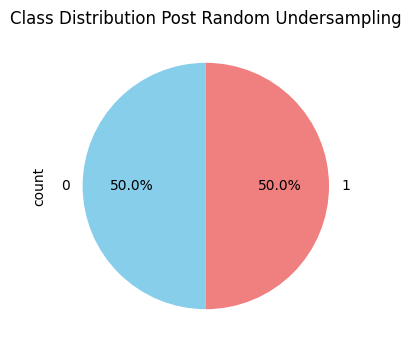

In [30]:
plot_resampling_results(y_rus, 'Class Distribution Post Random Undersampling')

###### Lets see the impact of random undersampling!

In [33]:
xgb_rus_v1 = XGBoostClassifierModel()

In [34]:
xgb_rus_v1.tune_hyperparameters(X_rus, y_rus, param_grid)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [35]:
xgb_rus_v1.fit_with_best_params(X_rus, y_rus, X_test, y_test)

C:\Users\oshan\anaconda3\envs\XGBoost\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\oshan\anaconda3\envs\XGBoost\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.69140
[1]	validation_0-auc:0.70627
[2]	validation_0-auc:0.71326
[3]	validation_0-auc:0.71872
[4]	validation_0-auc:0.72010
[5]	validation_0-auc:0.72227
[6]	validation_0-auc:0.72205
[7]	validation_0-auc:0.72517
[8]	validation_0-auc:0.72840
[9]	validation_0-auc:0.72982
[10]	validation_0-auc:0.73112
[11]	validation_0-auc:0.73216
[12]	validation_0-auc:0.73385
[13]	validation_0-auc:0.73525
[14]	validation_0-auc:0.73667
[15]	validation_0-auc:0.73765
[16]	validation_0-auc:0.73851
[17]	validation_0-auc:0.73902
[18]	validation_0-auc:0.73920
[19]	validation_0-auc:0.74047
[20]	validation_0-auc:0.74111
[21]	validation_0-auc:0.74230
[22]	validation_0-auc:0.74267
[23]	validation_0-auc:0.74351
[24]	validation_0-auc:0.74423
[25]	validation_0-auc:0.74456
[26]	validation_0-auc:0.74509
[27]	validation_0-auc:0.74513
[28]	validation_0-auc:0.74620
[29]	validation_0-auc:0.74684
[30]	validation_0-auc:0.74727
[31]	validation_0-auc:0.74745
[32]	validation_0-auc:0.74807
[33]	validation_0-au

In [36]:
y_pred = xgb_rus_v1.predict(X_test)

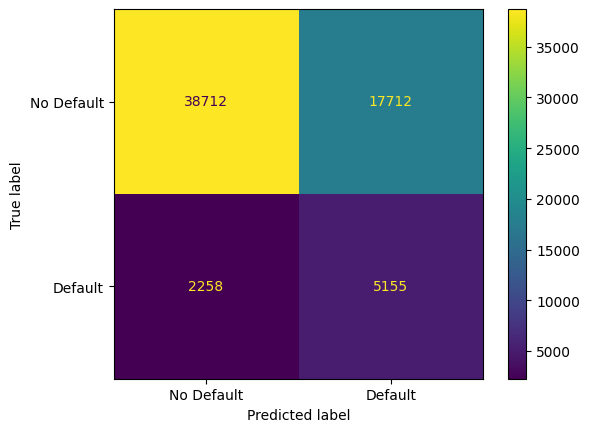

In [37]:
conf_m = xgb_rus_v1.plot_confusion_matrix(y_test, y_pred, labels=['No Default', 'Default'])

In [38]:
xgb_rus_v1.get_metrics(conf_m)

Precision: 0.22543403157388375
Recall: 0.6953999730203696
F1 Score: 0.3404887714663144


{'Precision': 0.22543403157388375,
 'Recall': 0.6953999730203696,
 'F1 Score': 0.3404887714663144}

###### We see our F1 score increased by roughly 24%, however, thie is still not an optimal performance

#### Oversampling

To put it simply, oversampling refers to adding instances of the minority class in the training dataset until a closer class distribution is present. These instances can be creates in diferent ways, depending on the technique you are using. It is important to only perform this on the training set and not the test set. This is because, you want your test set to remain as close as possible to the environment which the model will be deployed. 

##### Random Oversampling

In [49]:
from imblearn.over_sampling import RandomOverSampler

In [51]:
ros = RandomOverSampler(random_state=42)

In [52]:
X_ros, y_ros = ros.fit_resample(X_train, y_train)

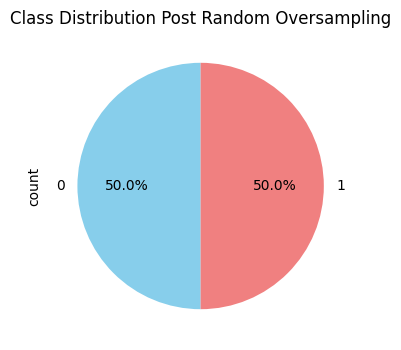

In [53]:
plot_resampling_results(y_ros, 'Class Distribution Post Random Oversampling')

In [54]:
xgb_ros_v1 = XGBoostClassifierModel()

In [55]:
xgb_ros_v1.tune_hyperparameters(X_ros, y_ros, param_grid)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600}


In [56]:
xgb_ros_v1.fit_with_best_params(X_ros, y_ros, X_test, y_test)

C:\Users\oshan\anaconda3\envs\XGBoost\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\oshan\anaconda3\envs\XGBoost\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71968
[1]	validation_0-auc:0.72791
[2]	validation_0-auc:0.73102
[3]	validation_0-auc:0.73375
[4]	validation_0-auc:0.73522
[5]	validation_0-auc:0.73611
[6]	validation_0-auc:0.73749
[7]	validation_0-auc:0.73823
[8]	validation_0-auc:0.73910
[9]	validation_0-auc:0.74037
[10]	validation_0-auc:0.74137
[11]	validation_0-auc:0.74185
[12]	validation_0-auc:0.74275
[13]	validation_0-auc:0.74360
[14]	validation_0-auc:0.74406
[15]	validation_0-auc:0.74516
[16]	validation_0-auc:0.74596
[17]	validation_0-auc:0.74668
[18]	validation_0-auc:0.74764
[19]	validation_0-auc:0.74830
[20]	validation_0-auc:0.74900
[21]	validation_0-auc:0.74996
[22]	validation_0-auc:0.75044
[23]	validation_0-auc:0.75094
[24]	validation_0-auc:0.75144
[25]	validation_0-auc:0.75195
[26]	validation_0-auc:0.75224
[27]	validation_0-auc:0.75279
[28]	validation_0-auc:0.75314
[29]	validation_0-auc:0.75355
[30]	validation_0-auc:0.75387
[31]	validation_0-auc:0.75418
[32]	validation_0-auc:0.75463
[33]	validation_0-au

In [57]:
y_pred = xgb_ros_v1.predict(X_test)

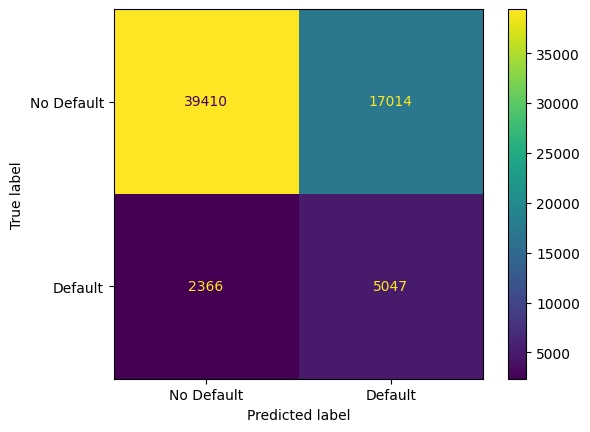

In [58]:
conf_m = xgb_ros_v1.plot_confusion_matrix(y_test, y_pred, labels=['No Default', 'Default'])

In [59]:
xgb_ros_v1.get_metrics(conf_m)

Precision: 0.22877476089025883
Recall: 0.6808309726156752
F1 Score: 0.34247133066431434


{'Precision': 0.22877476089025883,
 'Recall': 0.6808309726156752,
 'F1 Score': 0.34247133066431434}

###### We see our F1 score just slightly higher than the random undersampling technique